In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dataframe_image as dfi

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings(action='ignore')

import pickle

In [8]:
# 데이터프레임을 그림 파일로 저장
save_option = 1 # 1 : dfi / 2 : df2img / 3 : do nothing
import df2img
def savedf(df:pd.DataFrame, path:str):
    if save_option == 1:
        dfi.export(df, path)
    if save_option == 2:
        df2img.save_dataframe(fig=df2img.plot_dataframe(df), filename=path)
    if save_option == 3:
        pass

In [9]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:\Windows\Fonts\malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 데이터 불러오기 및 병합

In [10]:
collected_data = pd.read_csv('../../data/data_c_final/2c201_1230_collected_data.csv')
collected_data.set_index("지역", inplace=True)
collected_data.head()

,쏘카존 수,인구,2030인구,아파트 수,행복주택 수,지하철역 수,환승역 수,정류장 수,대학교 수,대학생 수,녹지,주거,공업,상업,위도,경도,면적
지역,,,,,,,,,,,,,,,,,
수원시 장안구,18,271012,82294.55980,200,0,1,0,409,0,34441,0.272727,0.727273,0.000000,0.000000,37.303971,127.001743,33.34
수원시 권선구,16,367004,111443.15610,159,1,4,0,537,0,11033,0.625000,0.312500,0.062500,0.000000,37.257687,126.963532,47.17
수원시 팔달구,20,192225,58370.37385,65,1,4,2,185,0,0,0.136364,0.409091,0.000000,0.454545,37.282570,127.011718,12.86
수원시 영통구,34,360127,109354.91020,129,3,6,0,380,0,22911,0.142857,0.571429,0.285714,0.000000,37.259600,127.042341,27.72
용인시 처인구,29,259872,67270.69540,112,1,9,0,1234,0,13084,0.823529,0.058824,0.000000,0.117647,37.234346,127.192965,467.65


In [11]:
# collected_data.sort_values(by='지역',inplace=True)
# collected_data['dumb'] = np.arange(len(collected_data))
# collected_data

In [13]:
hackathon_data_original = pd.read_csv("../../../socar_data/20211022_수요예측_hackathon_data.csv", encoding='cp949')
hackathon_data_original.head()

,region1,region2,reservation_return_at,reservation_start_at,age_group,gender,car_model
0,울산광역시,남구,2019-09-29 21:25:40+00:00,2019-09-29 19:20:00+00:00,1,male,경형
1,울산광역시,남구,2019-07-13 13:11:21+00:00,2019-07-13 11:00:00+00:00,1,male,준중형
2,울산광역시,남구,2019-09-16 23:43:08+00:00,2019-09-16 19:10:00+00:00,1,male,준중형
3,울산광역시,남구,2019-08-09 06:17:41+00:00,2019-08-09 00:20:00+00:00,1,male,준중형
4,울산광역시,남구,2019-07-24 12:36:29+00:00,2019-07-24 09:00:00+00:00,2,male,경형


In [15]:
with open('../code_a_collect_data/results/1b203_0208_remove_u3000.pkl', 'rb') as f:
    remove_u3000 = pickle.load(f)

In [16]:
hackathon_data = pd.DataFrame(hackathon_data_original['region2'].value_counts())
hackathon_data.reset_index(inplace=True)
hackathon_data['index'].replace(remove_u3000, inplace=True)
hackathon_data.columns = ['지역', '이용 수']
hackathon_data.set_index('지역', inplace=True)
hackathon_data.head()

,이용 수
지역,
성남시 분당구,46782
화성시,35249
고양시 일산동구,31906
남양주시,26546
고양시 덕양구,26253


In [17]:
intersected_rows = set.intersection(set(collected_data.index), set(hackathon_data.index))
intersected_rows = list(intersected_rows)
print(len(intersected_rows),'개 지역 \n',intersected_rows)

16 개 지역 
 ['양평군', '안양시 만안구', '고양시 덕양구', '안양시 동안구', '화성시', '하남시', '성남시 중원구', '남양주시', '성남시 수정구', '구리시', '광명시', '김포시', '의정부시', '고양시 일산서구', '성남시 분당구', '고양시 일산동구']


In [19]:
collected_data_intersected = collected_data[collected_data.index.isin(intersected_rows)]
collected_data_intersected.sort_index(ascending=True, inplace=True)
hackathon_data_intersected = hackathon_data[hackathon_data.index.isin(intersected_rows)]
hackathon_data_intersected.sort_index(ascending=True, inplace=True)
intersected = pd.concat([collected_data_intersected, hackathon_data_intersected],axis=1)
intersected['쏘카존 수 대비 이용 수'] = intersected['이용 수']/intersected['쏘카존 수']
intersected.head()

,쏘카존 수,인구,2030인구,아파트 수,행복주택 수,지하철역 수,환승역 수,정류장 수,대학교 수,대학생 수,녹지,주거,공업,상업,위도,경도,면적,이용 수,쏘카존 수 대비 이용 수
지역,,,,,,,,,,,,,,,,,,,
고양시 덕양구,48,487874,131281.05900,274,8,9,2,1205,0,4210,0.656250,0.343750,0.0,0.000000,37.637431,126.823745,165.0,26253,546.937500
고양시 일산동구,51,296590,79808.82212,133,0,6,0,454,0,13923,0.461538,0.461538,0.0,0.076923,37.658622,126.771006,59.0,31906,625.607843
고양시 일산서구,29,290738,78234.11890,140,0,4,0,635,0,0,0.500000,0.375000,0.0,0.125000,37.677991,126.741105,42.0,16052,553.517241
광명시,28,288182,76757.00000,89,0,3,0,445,0,0,0.222222,0.666667,0.0,0.111111,37.478618,126.856271,38.5,22645,808.750000
구리시,19,188876,51033.00000,111,1,2,0,313,0,0,0.500000,0.500000,0.0,0.000000,37.594266,127.121253,33.3,13011,684.789474


## 상관분석 (pearson correlation analysis)

In [20]:
correlation = intersected.corr()[['이용 수', '쏘카존 수 대비 이용 수']]
correlation['abs value'] = abs(correlation['이용 수'])
correlation.sort_values(by='abs value', ascending=False, inplace=True)
correlation.drop(columns = ['abs value'], inplace=True)
correlation.drop(index = ['이용 수', '쏘카존 수 대비 이용 수'], inplace=True)
correlation

,이용 수,쏘카존 수 대비 이용 수
쏘카존 수,0.806230,-0.537069
2030인구,0.686101,-0.334138
인구,0.649762,-0.390717
환승역 수,0.637355,0.078405
아파트 수,0.623385,-0.388349
경도,-0.393671,0.128923
주거,0.381949,0.060353
녹지,-0.369392,-0.148646
정류장 수,0.335510,-0.491441
지하철역 수,0.286200,-0.312177


In [21]:
correlation = correlation[['이용 수']]
correlation.columns = ['correlation']
correlation

,correlation
쏘카존 수,0.806230
2030인구,0.686101
인구,0.649762
환승역 수,0.637355
아파트 수,0.623385
경도,-0.393671
주거,0.381949
녹지,-0.369392
정류장 수,0.335510
지하철역 수,0.286200


In [22]:
savedf(correlation, "results/1b201_0112_correlation_analysis.png")
savedf(correlation.drop(index=['위도', '경도', '면적']), "results/1b202_0112_correlation_analysis_selected.png")

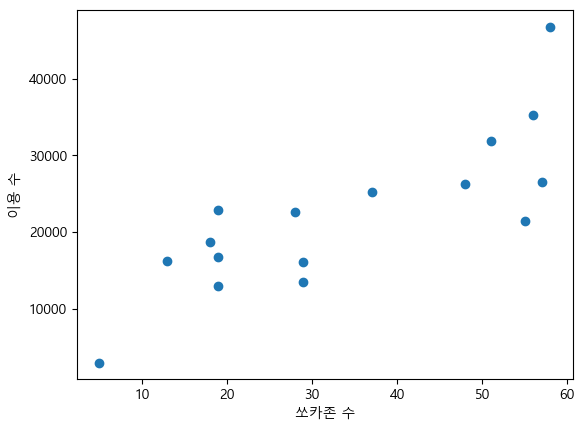

In [23]:
# 이용 수와 쏘카존 수 사이의 scatter plot
plt.xlabel('쏘카존 수')
plt.ylabel('이용 수')
plt.scatter(intersected['쏘카존 수'], intersected['이용 수'])
plt.show()

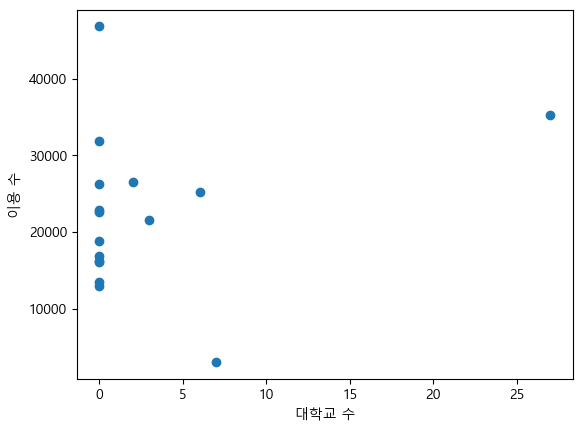

In [24]:
# 대학교 수와 쏘카존 수 사이의 scatter plot
plt.xlabel('대학교 수')
plt.ylabel('이용 수')
plt.scatter(intersected['대학교 수'], intersected['이용 수'])
plt.show()

## 회귀분석 (linear regression analysis)

## 회귀분석 (1)

In [25]:
# 독립변수 / 종속변수 설정
independents = intersected.copy()
independents = independents.drop(["이용 수", "쏘카존 수 대비 이용 수"], axis=1)
dependent = intersected["이용 수"]
independents.shape, dependent.shape

((16, 17), (16,))

In [26]:
# 위치 관련 feature 제거
independents = independents.drop(["위도", "경도", '면적'], axis=1)

In [27]:
# min max scaling
scaler = MinMaxScaler()
independents_scaled = scaler.fit_transform(independents.to_numpy())
independents_scaled = pd.DataFrame(independents_scaled, columns=independents.columns, index=independents.index)
independents_scaled.head()

,쏘카존 수,인구,2030인구,아파트 수,행복주택 수,지하철역 수,환승역 수,정류장 수,대학교 수,대학생 수,녹지,주거,공업,상업
지역,,,,,,,,,,,,,,
고양시 덕양구,0.811321,0.465198,0.460164,0.673352,0.470588,0.40,0.666667,0.363844,0.0,0.210279,0.558036,0.458333,0.0,0.000000
고양시 일산동구,0.867925,0.221678,0.244822,0.269341,0.000000,0.25,0.000000,0.077422,0.0,0.695420,0.307692,0.615385,0.0,0.615385
고양시 일산서구,0.452830,0.214228,0.238234,0.289398,0.000000,0.15,0.000000,0.146453,0.0,0.000000,0.357143,0.500000,0.0,1.000000
광명시,0.433962,0.210974,0.232054,0.143266,0.000000,0.10,0.000000,0.073989,0.0,0.000000,0.000000,0.888889,0.0,0.888889
구리시,0.264151,0.084549,0.124434,0.206304,0.058824,0.05,0.000000,0.023646,0.0,0.000000,0.357143,0.666667,0.0,0.000000


In [28]:
# variance inflation factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    independents_scaled.values, i) for i in range(independents_scaled.shape[1])]
vif["features"] = independents_scaled.columns
vif.sort_values(by='VIF Factor', ascending=True)


,VIF Factor,features
9,1.823866,대학생 수
12,2.311329,공업
13,3.106614,상업
5,7.142172,지하철역 수
6,8.322978,환승역 수
0,8.749077,쏘카존 수
4,12.669700,행복주택 수
10,19.949106,녹지
11,32.748353,주거
3,34.547917,아파트 수


In [29]:
# feature 제거 1 : 인구, 2030인구
independents_scaled.drop(['인구', '2030인구'], axis=1, inplace=True)

In [30]:
# variance inflation factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    independents_scaled.values, i) for i in range(independents_scaled.shape[1])]
vif["features"] = independents_scaled.columns
vif.sort_values(by='VIF Factor', ascending=True)


,VIF Factor,features
7,1.313850,대학생 수
4,1.702395,환승역 수
10,1.702813,공업
11,2.244104,상업
3,2.255222,지하철역 수
8,4.408969,녹지
0,4.763344,쏘카존 수
2,5.395858,행복주택 수
6,5.772101,대학교 수
9,6.572126,주거


In [31]:
# feature 제거 2 : 아파트 수, 정류장 수
independents_scaled.drop(['정류장 수', '아파트 수'], axis=1, inplace=True)

In [32]:
# variance inflation factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    independents_scaled.values, i) for i in range(independents_scaled.shape[1])]
vif["features"] = independents_scaled.columns
vif.sort_values(by='VIF Factor', ascending=True)


,VIF Factor,features
5,1.190228,대학생 수
2,1.490192,지하철역 수
3,1.509816,환승역 수
8,1.686898,공업
9,2.117464,상업
0,2.309346,쏘카존 수
6,2.923789,녹지
4,3.107504,대학교 수
1,4.177658,행복주택 수
7,5.140887,주거


In [33]:
y = dependent
x = independents_scaled
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   이용 수   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     19.12
Date:                Wed, 08 Feb 2023   Prob (F-statistic):           0.000938
Time:                        14:45:50   Log-Likelihood:                -142.73
No. Observations:                  16   AIC:                             305.5
Df Residuals:                       6   BIC:                             313.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
쏘카존 수       2.006e+04   3430.957      5.848      0.0

In [34]:
regression = pd.DataFrame(model.params, columns=['coefficients'])
regression['abs coef.'] = abs(regression['coefficients'])
regression.sort_values(by='abs coef.', ascending=False, inplace=True)
regression.drop(columns = ['abs coef.'], inplace=True)
regression

,coefficients
행복주택 수,-23152.979743
쏘카존 수,20063.427497
대학교 수,15640.193066
환승역 수,14502.791834
주거,14476.872484
대학생 수,5909.983450
공업,3688.515385
지하철역 수,3442.361033
상업,1442.959811
녹지,-74.874850


In [35]:
savedf(regression, "results/1b203_0201_regression_analysis.png")